# Micro-narrative analysis of _The Lord of the Rings_

In [1]:
import glob
import pandas as pd
import re

docs = []
section_splitter = re.compile(r"(?<=\S)\n\n(?=\S)|\n{3}")  # double line break surrounded by something else than whitespace, to keep poems/songs together
for file in glob.glob("input/*.txt"):
    with open(file) as f:
        text = f.read()
        sections = section_splitter.split(text)
        for section in sections:
            section = section.strip()
            if section:
                docs.append(section)

In [2]:
from narrativegraphs import CooccurrenceGraph
import os.path

if os.path.exists("lotr.db"):
    model = CooccurrenceGraph.load("lotr.db")
else:
    model = CooccurrenceGraph(
        sqlite_db_path="lotr.db",
        on_existing_db="overwrite",
        n_cpu=1
    ).fit(docs)

INFO:narrativegraphs.pipeline:Adding 638 documents to database
INFO:narrativegraphs.pipeline:Extracting entities


Extracting entities:   0%|          | 0/638 [00:00<?, ?it/s]

INFO:narrativegraphs.pipeline:Resolving entities
INFO:narrativegraphs.pipeline:Mapping tuplets
INFO:narrativegraphs.pipeline:Calculating stats


In [3]:
# here, we can interactively inspect the cooccurrence graph
# model.serve_visualizer()

## Distribution of entities

Below, we will look at the distribution of extracted entities. As for single-word distributions, we expect to be in the central Large Number of Rare Events (LNRE) zone where we see a long tail of distinct, rare entities. The number of distinct entities (our vocabulary) grows with the size of the corpus. Additionally, according to Zipf's law, we should see that the most frequent entities make up a considerable portion of the total number of entity occurrences.

We will look at both unresolved entity mentions and resolved entity mentions, but onwards we will use the resolved entities.

In [4]:
from sharedutils import fit_and_visualize_entity_frequencies

unresolved_ents_df = model.entity_mentions_.groupby("entity_span_text").size().reset_index(name="frequency")
resolved_ents_df = model.entities_

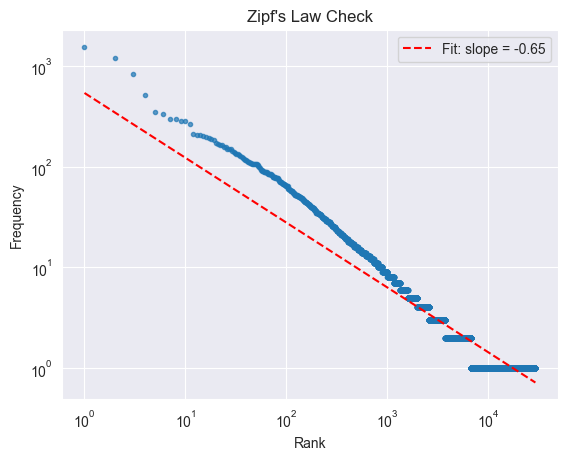

In [5]:
fit_and_visualize_entity_frequencies(unresolved_ents_df)

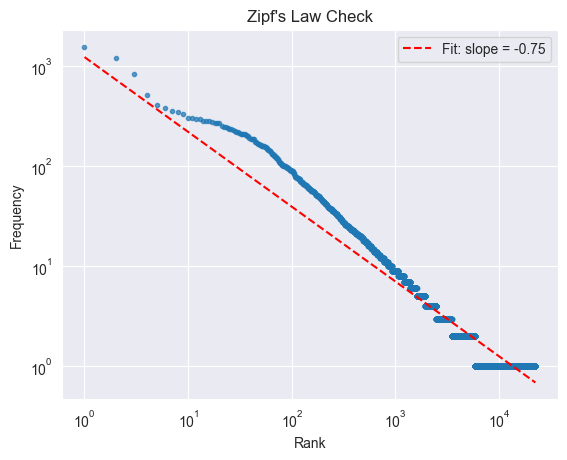

In [6]:
fit_and_visualize_entity_frequencies(resolved_ents_df)

Both roughly fit a Zipfian distribituion. The resolved entities have a slightly steeper slope as "the rich get richer" by adding lower frequency counts of some entities to other entities. Hence, the ranked list becomes shorter, but the total number of entity occurrences are the same.

In this analysis, we are interested in the lower end of the tail: the large number of rare entities. We try to see how these many distinct but rare entities fit into the narrative.

We see a significant portion of hapax legomena – single occurrence entities. While these may also be meaningful, this is also where we see the most noise from extraction errors.

In [7]:
model.entities_[model.entities_.frequency == 1]

,id,label,frequency,doc_frequency,spread,adjusted_tf_idf,alt_labels
16,17,the Great War of the,1,1,0.001567,0.0,[]
18,19,many glimpses,1,1,0.001567,0.0,[]
19,20,the yet more ancient history,1,1,0.001567,0.0,[]
21,22,its publication,1,1,0.001567,0.0,[]
22,23,1937,1,1,0.001567,0.0,[]
...,...,...,...,...,...,...,...
22369,22370,Frodo bore,1,1,0.001567,0.0,[]
22370,22371,the High Sea,1,1,0.001567,0.0,[]
22371,22372,last on a night,1,1,0.001567,0.0,[]
22372,22373,silver glass,1,1,0.001567,0.0,[]


So, from here and onwards we will consider entities with a frequency above 1.

This means that we will filter the graph as follows:

In [8]:
from narrativegraphs import GraphFilter

graph_filter = GraphFilter(
    minimum_node_frequency=2,
)

## PMI weighting of entity cooccurrences

In our fitted cooccurrence graph, we can calculate pointwise mutual information between entities $A$ and $B$:

$PMI(A, B) = \log \frac{P(A, B)}{P(A)P(B)}$

PMI is known to inflate for rare events. And more generally, it is higher for lower frequency items, as seen below.

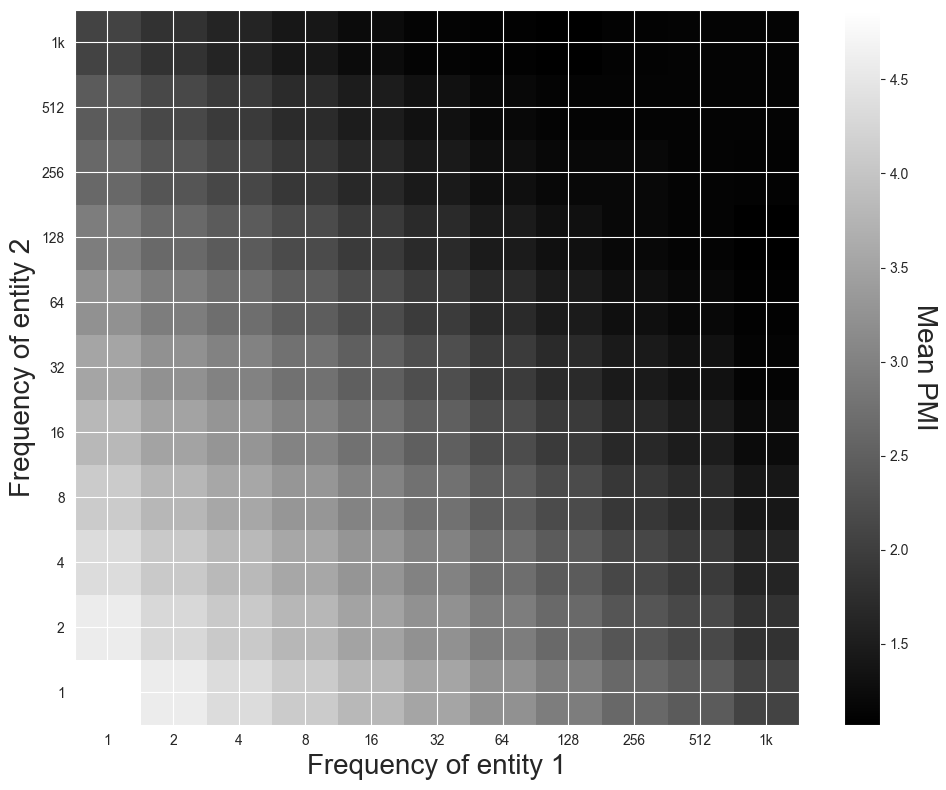

In [9]:
from sharedutils import visualize_pmi_by_frequency

visualize_pmi_by_frequency(model.cooccurrences_)

This means – one of the core hypotheses of this analysis – that if we weight edges in our graph with PMI and/or filter edges by PMI, we can surface the rare entity connections as well as particularly strong connections with the more frequent entities.

We can sort of eyeball which area we are interested in: anything above 3 will on average retain half of connections in the 200-300'ish area and therefore even more in the lower end.

In [10]:
min_weight = 2.5

## Community detection

We will use two methods, inspect their results and compare them.

k-clique community detection finds all communities of k-cliques and further merges those that share k-1 nodes. It allows for overlapping communities.

There are two hyperparameters:
- k: the minimum size of a clique. The smaller, the more small cliques we get, but the more merged cliques in bigger communities we get.
- w: the minimum weight of an edge, in our case PMI.

A thing that tends to happen according to the authors of the method is that one giant community tends to show up that eats up a lot of smaller communities and that some of this can be alleviated by tuning on the "right" hyper-parameters. But we may also interpret this differently: this giant community means that whatever micro-narratives are in there are not sufficiently delimited from the general narrative. We will keep this community on the side and not mix them in with the rest of the smaller ones.

For starters, we let k=3 to allow for the smalles meaningful communities. k=2 essentially yields connected components (since it merges all connected nodes) and is therefore too small.

In [11]:
k_clique_comms = model.graph.find_communities(
    graph_filter=graph_filter,
    min_weight=min_weight,
    community_detection_method_args=dict(k=4)
)

k_clique_comms_with_contexts = []
k_clique_big_comms = []
last_size = None
for comm in sorted(k_clique_comms, key=lambda c: len(c.members)):
    size = len(comm.members)
    if size < 2:
        continue
    if last_size and size > 2 * last_size:
        k_clique_big_comms.append(comm)
        continue
    contexts = model.tuplets.get_contexts_by_entity_ids(comm.member_ids)
    contexts.sort(key=lambda c: c.doc_id)
    k_clique_comms_with_contexts.append((comm, contexts))
    last_size = size

print(len(k_clique_big_comms))
print(*[len(comm.members) for comm in k_clique_big_comms], sep=', ')

2
114, 4031


Louvain community detection finds communities by optimizing towards modularity, merging smaller communities into bigger ones iteratively while modularity increases. It creates non-overlapping communities.

There are several hyper-parameters, but we consider only:
- resolution: higher values result in smaller communities.
- w: the minimum weight of an edge, in our case PMI.

In [12]:
louvain_comms = model.graph.find_communities(
    graph_filter=graph_filter,
    community_detection_method="louvain",
    community_detection_method_args=dict(resolution=50)
)
louvain_comms_with_contexts = []

for comm in sorted(louvain_comms, key=lambda c: c.score, reverse=True):
    size = len(comm.members)
    if size < 2 or size > 1000 : continue
    contexts = model.tuplets.get_contexts_by_entity_ids(comm.member_ids)
    contexts.sort(key=lambda c: c.doc_id)
    louvain_comms_with_contexts.append((comm, contexts))

Let us get a sense of what kinds of communities we get from the two methods.

## Comparison of k-clique and Louvain

In [13]:
comms_by_method = {
    "k_clique": k_clique_comms_with_contexts,
    "louvain": louvain_comms_with_contexts
}

In [14]:
import numpy as np

# Extract sizes for each method
sizes_by_method = {
    method: [len(comm.members) for comm, contexts in comms_with_contexts]
    for method, comms_with_contexts in comms_by_method.items()
}

for name, comms in sizes_by_method.items():
    print(name)
    print("N:", len(comms))
    print("Mean:", np.mean(comms))
    print("Median:", np.median(comms))
    print()


k_clique
N: 1673
Mean: 7.557680812910938
Median: 6.0

louvain
N: 924
Mean: 6.091991341991342
Median: 6.0



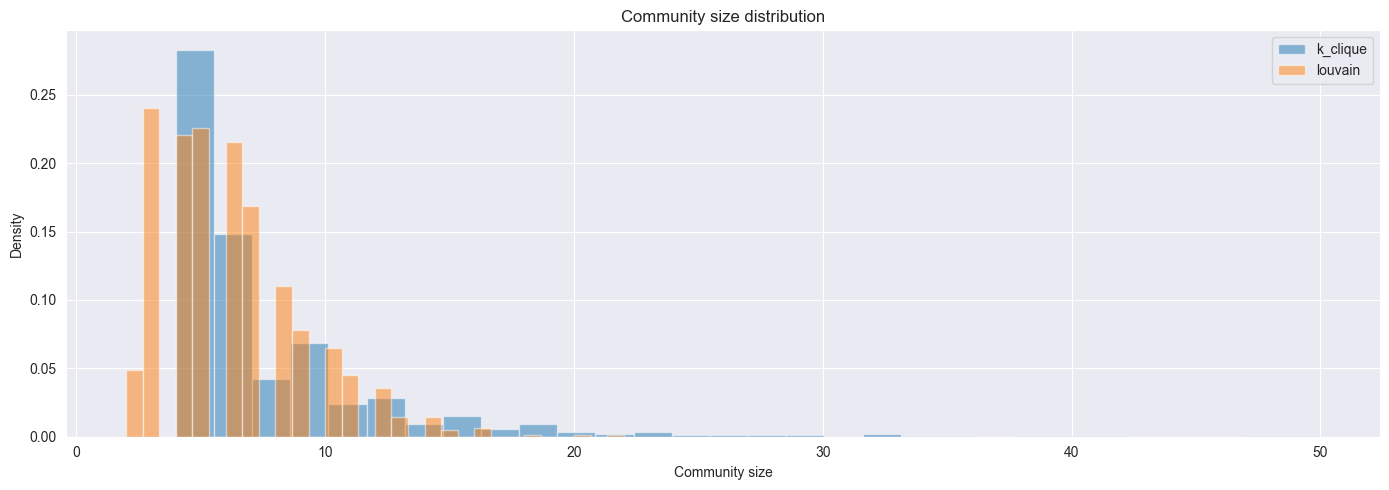

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(14, 5))

# Barplot: distribution of community sizes
x = np.arange(len(comms_by_method))
width = 0.35

# Density plot: full distributions
for method, sizes in sizes_by_method.items():
    ax.hist(sizes, bins=30, alpha=0.5, label=method, density=True)

ax.set_xlabel('Community size')
ax.set_ylabel('Density')
ax.set_title('Community size distribution')
ax.legend()

plt.tight_layout()
plt.show()

A noticeable difference is that Louvain appears to create fewer but bigger communities than k-clique. We can inspect some of the extracted communities and their contexts as follows.

In [16]:
from sharedutils import print_comm_with_contexts

import random
random.seed(42)
for method, comms_with_contexts in comms_by_method.items():
    print(method)
    sample = random.choices(comms_with_contexts, k=10)
    for comm, contexts in sample[:10]:
        print_comm_with_contexts(comm, contexts)

k_clique
COMMUNITY: the western end, the drum-beats, a horn-call, a flame, Doom, the hall, the pillars
ID: 124, OFFSET: 812
Slowly the hall filled, and Frodo looked with delight upon the many fair faces that were gathered together; the golden firelight played upon them and shimmered in their hair. Suddenly he noticed, not far from the further end of the fire, a small dark figure seated on a stool with his back propped against a pillar. Beside him on the ground was a drinking-cup and some bread. Frodo wondered whether he was ill (if people were ever ill in Rivendell), and had been unable to come to the feast.
ID: 177, OFFSET: 213
Doom, doom_ it rolled again, as if huge hands were turning the very caverns of Moria into a vast drum. Then there came an echoing blast: a great horn was blown in the hall, and answering horns and harsh cries were heard further off. There was a hurrying sound of many feet.
`They are coming! '
ID: 177, OFFSET: 672
We will see what -'
_Doom, doom_ came the dru

While these are just small samples from the two methods, it provides an important qualitative insight: the smaller communities generally seem more coherent in terms of "a reflected narrative" or thematic connections while the larger communities are more like amalgamations of smaller communities which lack clear coherence.

We will try to test this assumption be seeing whether the smaller communities of one are indeed contained by bigger ones in the other. 

In [17]:
def coverage(list_a: list[set], list_b: list[set]) -> float:
    scores = []
    lengths = []
    for a in list_a:
        if not a:
            continue
        best = max(len(a & b) / len(a) for b in list_b)
        scores.append(best)
        lengths.append(len(a))
    return sum(score * length for score, length in zip(scores, lengths)) / sum(lengths)

k_clique_comm_sets = [{e.id for e in comm.members} for comm, _ in k_clique_comms_with_contexts]
louvain_comm_sets = [{e.id for e in comm.members} for comm, _ in louvain_comms_with_contexts]
k_clique_big_comm_sets = [{e.id for e in comm.members} for comm in k_clique_big_comms]
print("k-clique covered by Louvain:", coverage(k_clique_comm_sets, louvain_comm_sets))
print("Louvain covered by k-clique:", coverage(louvain_comm_sets, k_clique_comm_sets))
print("Louvain covered by giant k-clique comm:", coverage(louvain_comm_sets, k_clique_big_comm_sets))

k-clique covered by Louvain: 0.30417589370452386
Louvain covered by k-clique: 0.5018653402025226
Louvain covered by giant k-clique comm: 0.6965713270563155


Our qualitative assessment is, to some degree, supported by this quantitative evidence. The k-clique communities are in general more contained by the Louvain communities than vice versa. Many of the Louvain communities are covered by the giant k-clique community, however.

In conclusion, for this analysis, where we are interested in micro-narratives – localized configurations of entities that together constitute recognizable subplots or thematic clusters – the smaller communities from k-clique would appear to be more valuable to us.

Therefore, we will dig more into those.

## Typology of k-clique communities

Intuitively, the micro-narratives can appear in a few ways, with these as reference points on a sort of continuum.

1. Appear once
2. Appear multiple times in close vicinity
3. Appear multiple times with great distance

From the earlier qualitative assessment, we saw that many appeared in just one short context snippet in one section of the book. These make up the bulk of the extracted micro-narratives.

### Single-spike micro-narratives

In [18]:
spike_values, spread_values = [], []
for comm, contexts in k_clique_comms_with_contexts:
    ids = {c.doc_id for c in contexts}
    spike_values.append(len(ids))
    spread_values.append(max(ids) - min(ids) + 1)

    
single_spike_count = sum(1 for sv in spike_values if sv == 1)
print('Single spike count:', single_spike_count, 'out of total', len(k_clique_comms_with_contexts))

Single spike count: 642 out of total 1673


We can dig qualitatively into some of these:

In [19]:
for (comm, contexts), sv in zip(k_clique_comms_with_contexts, spike_values):
    if sv > 1: continue
    print('COMMUNITY:', ', '.join(e.label for e in comm.members))
    for context in contexts:
        context.print_with_ansi_highlight()
    print()

COMMUNITY: the clearing, the White, Mortal Men, Dwimordene
ID: 283, OFFSET: 5986


     In Dwimordene, in Lórien
      Seldom have walked the feet of Men,
      Few mortal eyes have seen the light
      That lies there ever, long and bright.
      Galadriel! Galadriel!
      Clear is the water of your well;
      White is the star in your white hand;
      Unmarred, unstained is leaf and land
      In Dwimordene, in Lórien
      More fair than thoughts of Mortal Men.

COMMUNITY: a great strength, the threshold, a great cry, Mortal Men
ID: 540, OFFSET: 12245
And it was said that ever after, if any man looked in that Stone, unless he had a great strength of will to turn it to other purpose, he saw only two aged hands withering in flame.
Gandalf in grief and horror turned his face away and closed the door. For a while he stood in thought, silent upon the threshold, while those outside heard the greedy roaring of the fire within. And then Denethor gave a great cry, and afterwards spoke no 

These do indeed appear to be small clusters of rather specific mentions of rare entities. When one thinks about it, it makes sense that these surface as communities in a PMI-weighted graph: they are the rare connections of rare entities.

However, many of them are not so much delimited narratives as they are specific components of some slightly bigger narrative. As such, they are perhaps best classified as "peripheral narrative elements".

### Multi-spike micro-narratives

We will now dig into multi-spike micro-narratives and see how they are distributed in terms of spread and spikes.

We will operationalize spread as the floored log10 value. This reflects the order of magnitude of sections that a community spreads.

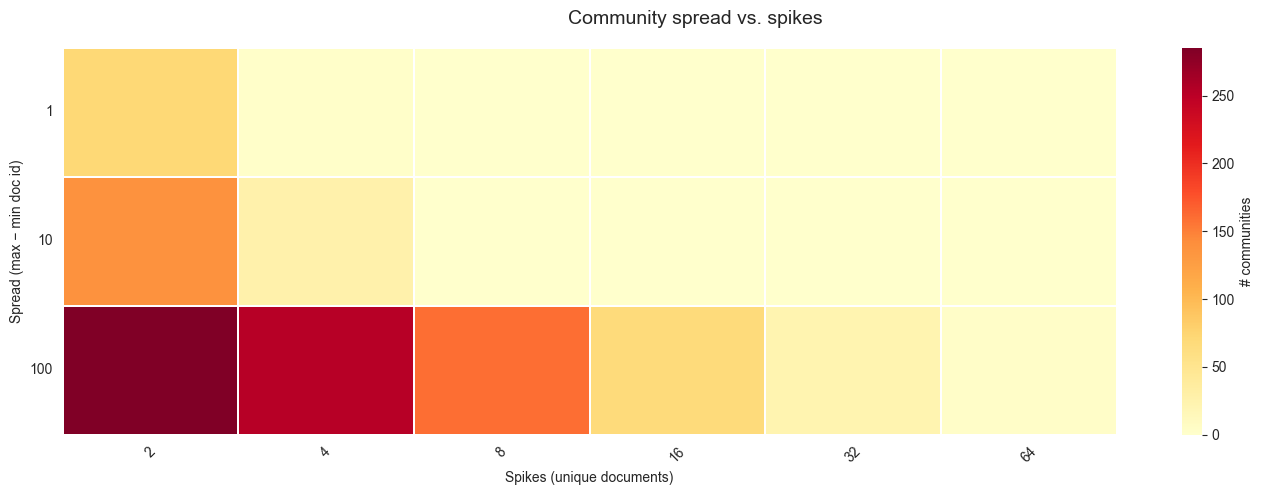

In [20]:
import math
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 5))

df = pd.DataFrame(dict(spikes=spike_values, spread=spread_values))
# remove single spikes
df = df[df.spikes > 1]

log_base = 10
df["floored_log_spread"] = np.floor(np.emath.logn(log_base, df.spread))
df["floored_log_spikes"] = np.floor(np.log2(df.spikes))

# Pivot to a 2D count matrix
heat = (
    df.groupby(["floored_log_spread", "floored_log_spikes"], observed=True)
    .size()
    .unstack(fill_value=0)
)

# Readable tick labels: use bin midpoints
x_labels = [f"{int(2 ** b)}" for b in heat.columns]
y_labels = [f"{int(log_base ** b)}" for b in heat.index]

sns.heatmap(
    heat,
    ax=ax,
    cmap="YlOrRd",
    xticklabels=x_labels,
    yticklabels=y_labels,
    linewidths=0.3,
    linecolor="white",
    cbar_kws={"label": "# communities"},
)

ax.set_xlabel("Spikes (unique documents)")
ax.set_ylabel("Spread (max − min doc id)")
ax.tick_params(axis="x", rotation=45)
ax.tick_params(axis="y", rotation=0)

plt.suptitle("Community spread vs. spikes", fontsize=14)
plt.tight_layout()
plt.show()

We will try to dig into these blocks

In [21]:
def activation_score(comm, contexts):
    """A score function to surface those micro-narratives that are the strongest activated in across their contexts"""
    members = {e.id for e in comm.members}
    scores = []
    for context in contexts:
        activated = {e.id for tuplet in context.tuplets
                     for e in [tuplet.entity_one, tuplet.entity_two]}
        scores.append(len(activated) / len(members))
    return np.mean(scores)

def slice_micro_narratives(min_spread, max_spread, min_spikes, max_spikes):
    sliced_df = df[
        (min_spread <= df.spread) & 
        (df.spread < max_spread) & 
        (min_spikes <= df.spikes) & 
        (df.spikes < max_spikes)
        ]
    print('Number of comms:', len(sliced_df))
    micro_narratives = [k_clique_comms_with_contexts[row[0]] for row in sliced_df.iterrows()]
    micro_narratives.sort(key=lambda tpl: activation_score(*tpl), reverse=True)
    return micro_narratives
    

def print_micro_narratives(min_spread, max_spread, min_spikes, max_spikes):
    for comm, context in slice_micro_narratives(min_spread, max_spread, min_spikes, max_spikes):
        print_comm_with_contexts(comm, context)

#### Adjacent sections, two or three spikes: Local description or event
These are not much longer than the single spike ones, but they do get re-activated across a section boundary.

In [22]:
print_micro_narratives(2, 4, 2, 4)

Number of comms: 30
COMMUNITY: Buckland, my advice, outlandish folk, the farmer
ID: 50, OFFSET: 11383

Frodo said nothing: the shrewd guesses of the farmer were rather disconcerting.
'Well, Mr. Frodo,' Maggot went on, 'I'm glad that you've had the sense to come back to Buckland. My advice is: stay there! And don't get mixed up with these outlandish folk. You'll have friends in these parts. If any of these black fellows come after you again, I'll deal with them.
ID: 52, OFFSET: 1848
That was the origin of Buckland, a thickly inhabited strip between the river and the Old Forest, a sort of colony from the Shire. Its chief village was Bucklebury, clustering in the banks and slopes behind Brandy Hall.
The people in the Marish were friendly with the Bucklanders, and the authority of the Master of the Hall (as the head of the Brandybuck family was called) was still acknowledged by the farmers between Stock and Rushey. But most of the folk of the old Shire regarded the Bucklanders as peculiar,

#### Low or moderate spread, multiple spikes: Atmospheres, world-building details or sub-plots
These are somewhat more persistent communities across three or more sections, but still limited in the text.

In [23]:
print_micro_narratives(4, 10, 4, 100)

Number of comms: 3
COMMUNITY: the drum-beats, your pack, our way, Doom
ID: 177, OFFSET: 672
We will see what -'
_Doom, doom_ came the drum-beat and the walls shook.
'Slam the doors and wedge them! ' shouted Aragorn. 'And keep your packs on as long as you can: we may get a chance to cut our way out yet.'
`No! ' said Gandalf. 'We must not get shut in.
ID: 180, OFFSET: 54
Doom, doom_ went the drum-beats again: they now sounded muffled and far away, but they were following. There was no other sound of pursuit, neither tramp of feet, nor any voice. Gandalf took no turns, right or left, for the passage seemed to be going in the direction that he desired. Every now and again it descended a flight of steps, fifty or more, to a lower level.
ID: 181, OFFSET: 2128

Even as he spoke they heard again the pursuing drum-beat: _Doom, doom, doom_. Away beyond the shadows at the western end of the hall there came cries and horn-calls. _Doom, doom_: the pillars seemed to tremble and the flames to quiv

In [24]:
print_micro_narratives(10, 100, 4, 100)

Number of comms: 28
COMMUNITY: a bog, the Withywindle, the forest, all the stories
ID: 52, OFFSET: 2777
It ran all the way from Brandywine Bridge, in a big loop curving away from the river, to Haysend (where the Withywindle flowed out of the Forest into the Brandywine): well over twenty miles from end to end. But, of course, it was not a complete protection. The Forest drew close to the hedge in many places. The Bucklanders kept their doors locked after dark, and that also was not usual in the Shire.
ID: 57, OFFSET: 1777
Near at hand the mist was now almost gone; though here and there it lay in hollows of the wood, and to the south of them, out of a deep fold cutting right across the Forest, the fog still rose like steam or wisps of white smoke.
'That,' said Merry, pointing with his hand, 'that is the line of the Withywindle. It comes down out of the Downs and flows south-west through the midst of the Forest to join the Brandywine below Haysend. We don't want to go _that_ way! The With

#### High spread, few spikes: Cross-textual echoes

In [25]:
print_micro_narratives(10, 100, 2, 4)

Number of comms: 137
COMMUNITY: many paths, Downs, And whither, weary feet
ID: 22, OFFSET: 26775
I am being swept off my feet at last,' he added, and then in a low voice, as if to himself, he sang softly in the dark:

     The Road goes ever on and on
       Down from the door where it began.
       Now far ahead the Road has gone,
       And I must follow, if I can,
      Pursuing it with eager feet,
       Until it joins some larger way
      Where many paths and errands meet.
       And whither then? I cannot say.
ID: 43, OFFSET: 19004
Suddenly he spoke, aloud but as if to himself, saying slowly:

     The Road goes ever on and on
       Down from the door where it began.
      Now far ahead the Road has gone,
       And I must follow, if I can,
      Pursuing it with weary feet,
       Until it joins some larger way,
      Where many paths and errands meet.
       And whither then? I cannot say.

COMMUNITY: a hood, its head, his pocket, the desire
ID: 44, OFFSET: 3134
The riding fi

In [26]:
print_micro_narratives(100, 1000, 2, 4)

Number of comms: 285
COMMUNITY: hardly a sound, a week, Spring, the willow-meads, Tasarinan
ID: 242, OFFSET: 3042
I used to spend a week just breathing.'
Treebeard fell silent, striding along, and yet making hardly a sound with his great feet. Then he began to hum again, and passed into a murmuring chant. Gradually the hobbits became aware that he was chanting to them:

     In the willow-meads of Tasarinan I walked in the Spring.
      Ah! the sight and the smell of the Spring in Nan-tasarion!
      And I said that was good.
ID: 612, OFFSET: 12663
Then in the willow-meads of Tasarinan we may meet in the Spring. Farewell!'
Last of all Merry and Pippin said good-bye to the old Ent, and he grew gayer as he looked at them. 'Well, my merry folk,' he said, 'will you drink another draught with me before you go?'

COMMUNITY: his father, Meriadoc, his people, That venture
ID: 206, OFFSET: 21089
That venture is desperate: as much so for eight as for three or two, or one alone. If you would let 

#### High spread, multiple spikes: recurring narrative elements and motifs

In [27]:
print_micro_narratives(100, 1000, 4, 8)

Number of comms: 252
COMMUNITY: the great tales, the point, Even Gollum, the book
ID: 2, OFFSET: 4013
Some who have read the book, or at any rate have reviewed it, have found it boring, absurd, or contemptible; and I have no cause to complain, since I have similar opinions of their works, or of the kinds of writing that they evidently prefer. But even from the points of view of many who have enjoyed my story there is much that fails to please. It is perhaps not possible in a long tale to please everybody at all points, nor to displease everybody at the same points; for I find from the letters that I have received that the passages or chapters that are to some a blemish are all by others specially approved. The most critical reader of all, myself, now finds many defects, minor and major, but being fortunately under no obligation either to review the book or to write it again, he will pass over these in silence, except one that has been noted by others: the book is too short.
As for any 

In [28]:
print_micro_narratives(100, 1000, 8, 16)

Number of comms: 160
COMMUNITY: his reckoning, more than one passage, the right, the left
ID: 57, OFFSET: 3813
The path that had brought them to the hill reappeared on the northward side; but they had not followed it far before they became aware that it was bending steadily to the right. Soon it began to descend rapidly and they guessed that it must actually be heading towards the Withywindle valley: not at all the direction they wished lo take. After some discussion they decided to leave this misleading path and strike northward; for although they had not been able to see it from the hill-top, the Road must lie that way, and it could not be many miles off. Also northward, and to the left of the path, the land seemed lo be drier and more open, climbing up to slopes where the trees were thinner, and pines and firs replaced the oaks and ashes and other strange and nameless trees of the denser wood.
ID: 57, OFFSET: 5262
Each time they climbed down they found the hollow filled with thick b